**Load Dataset**

In [1]:
# Install kaggle library
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smmmmmmmm","key":"7b133f9532960b035175029dd9cafb37"}'}

In [2]:
# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data
!unzip climate-change-earth-surface-temperature-data.zip

Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
License(s): CC-BY-NC-SA-4.0
 91% 77.0M/84.7M [00:00<00:00, 180MB/s]
100% 84.7M/84.7M [00:00<00:00, 158MB/s]
Archive:  climate-change-earth-surface-temperature-data.zip
  inflating: GlobalLandTemperaturesByCity.csv  
  inflating: GlobalLandTemperaturesByCountry.csv  
  inflating: GlobalLandTemperaturesByMajorCity.csv  
  inflating: GlobalLandTemperaturesByState.csv  
  inflating: GlobalTemperatures.csv  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


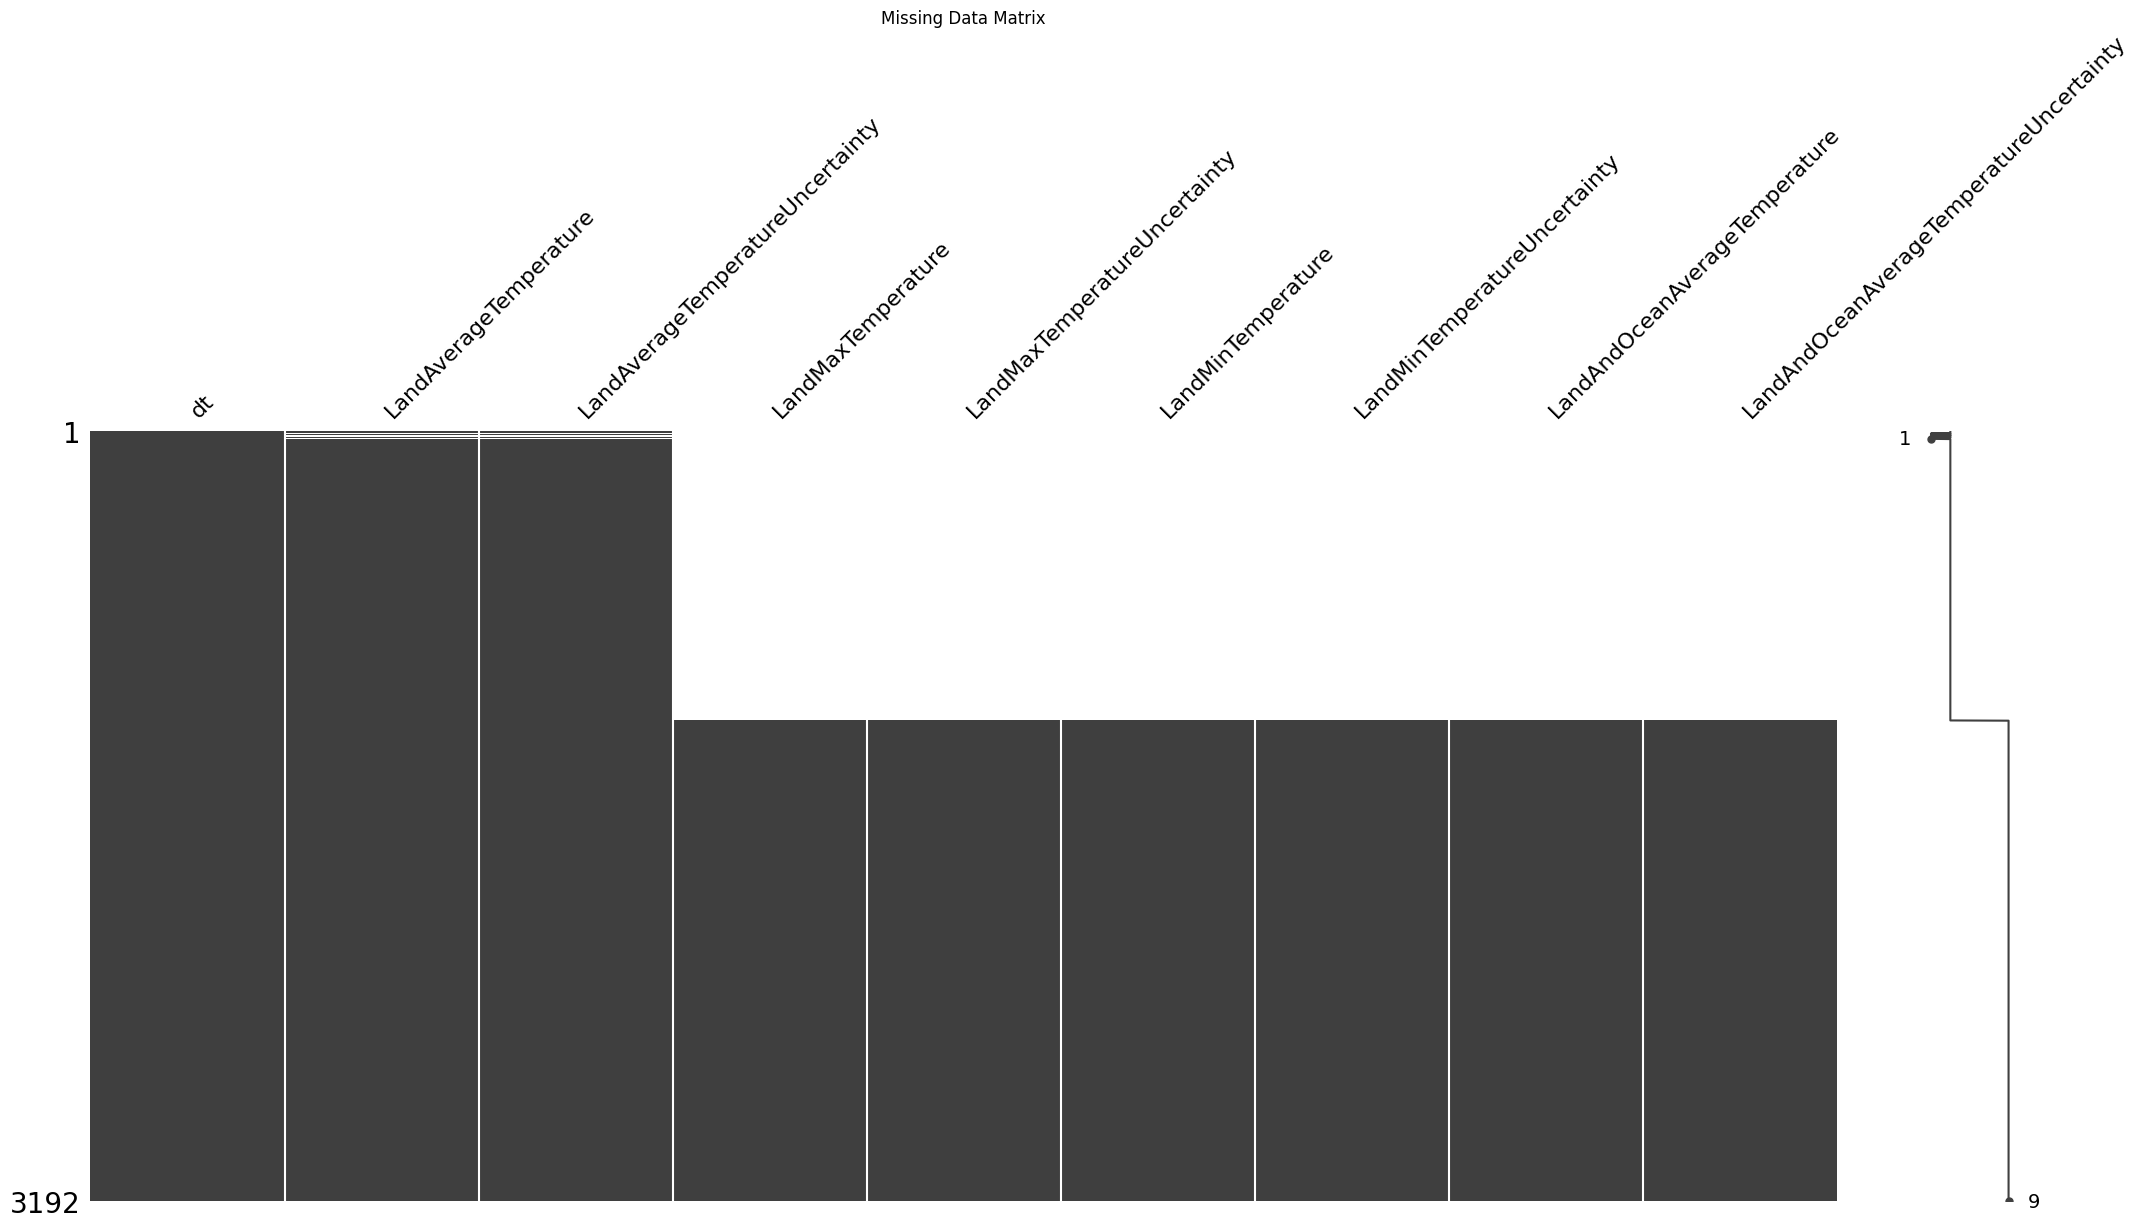

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the global temperatures dataset
temperature_data = pd.read_csv("GlobalTemperatures.csv")

# Basic information about the dataset
temperature_data.info()
temperature_data.describe()
temperature_data.head()

# Visualize missing data
import missingno as msno
msno.matrix(temperature_data)
plt.title("Missing Data Matrix")
plt.show()

**Exploratory Data Analysis**


---


Temperature Trends Over Time

In [7]:
# Temperature trends over time
temperature_data['dt'] = pd.to_datetime(temperature_data['dt'])
temperature_data.set_index('dt', inplace=True)

Global Average Land Temperature Over Time

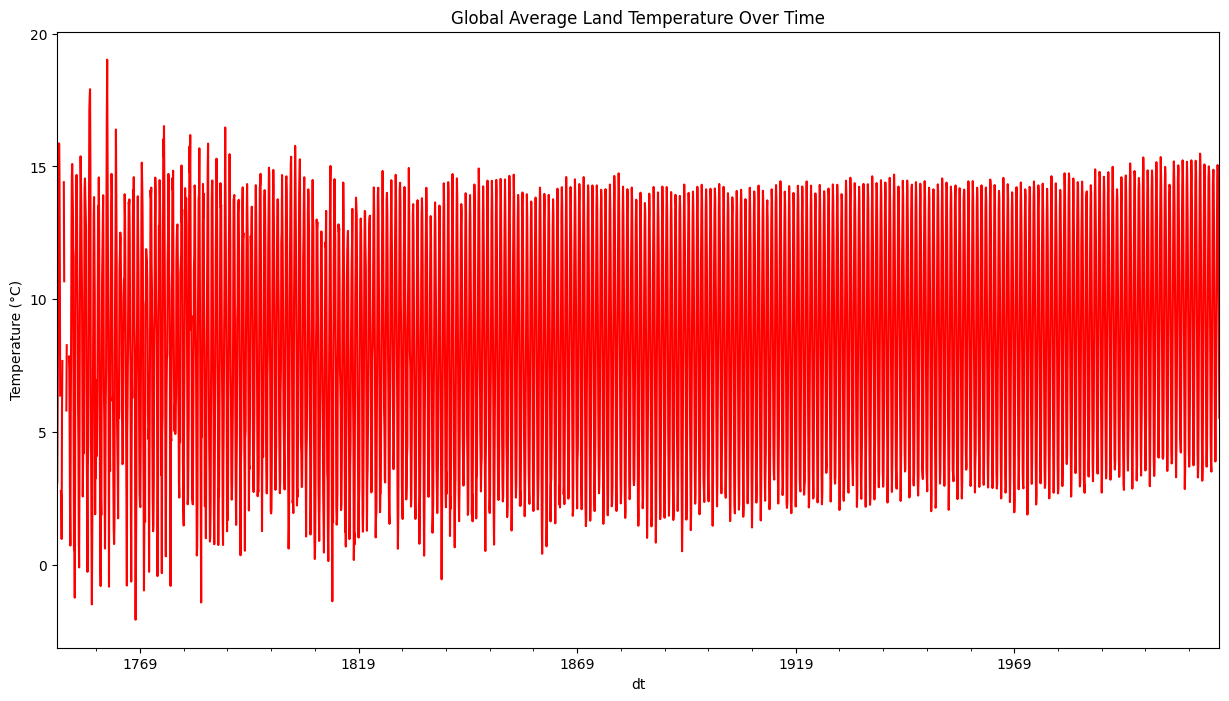

In [8]:
# Plot global temperature trends
plt.figure(figsize=(15, 8))
temperature_data['LandAverageTemperature'].plot(color='r')
plt.title('Global Average Land Temperature Over Time')
plt.ylabel('Temperature (°C)')
plt.show()

Monthly Average Temperature Trends

<ipython-input-10-8bb3bfa2dcae>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='coolwarm')


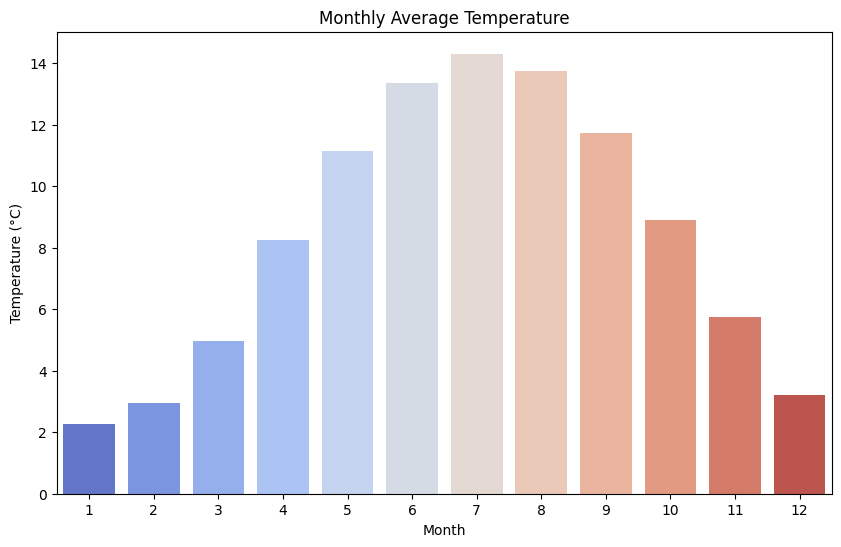

In [10]:
# Monthly average temperature trends
temperature_data['Month'] = temperature_data.index.month
monthly_avg = temperature_data.groupby('Month')['LandAverageTemperature'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='coolwarm')
plt.title('Monthly Average Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.show()

**Machine Learning Models**


---

Data Preprocessing

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Drop rows with missing values and extract features
temperature_data.dropna(subset=['LandAverageTemperature'], inplace=True)
X = temperature_data[['LandMaxTemperature', 'LandMinTemperature', 'LandAndOceanAverageTemperature']]
y = temperature_data['LandAverageTemperature']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Training


In [13]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = rf_model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 7.872695754506442
Mean Absolute Error: 1.6352096066723334
R^2 Score: 0.5752009006254102


**Forecasting**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuofg8ryq/e7aw06b1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuofg8ryq/tmxrjvug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52199', 'data', 'file=/tmp/tmpuofg8ryq/e7aw06b1.json', 'init=/tmp/tmpuofg8ryq/tmxrjvug.json', 'output', 'file=/tmp/tmpuofg8ryq/prophet_modelmgik7dfd/prophet_model-20241205161439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:14:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


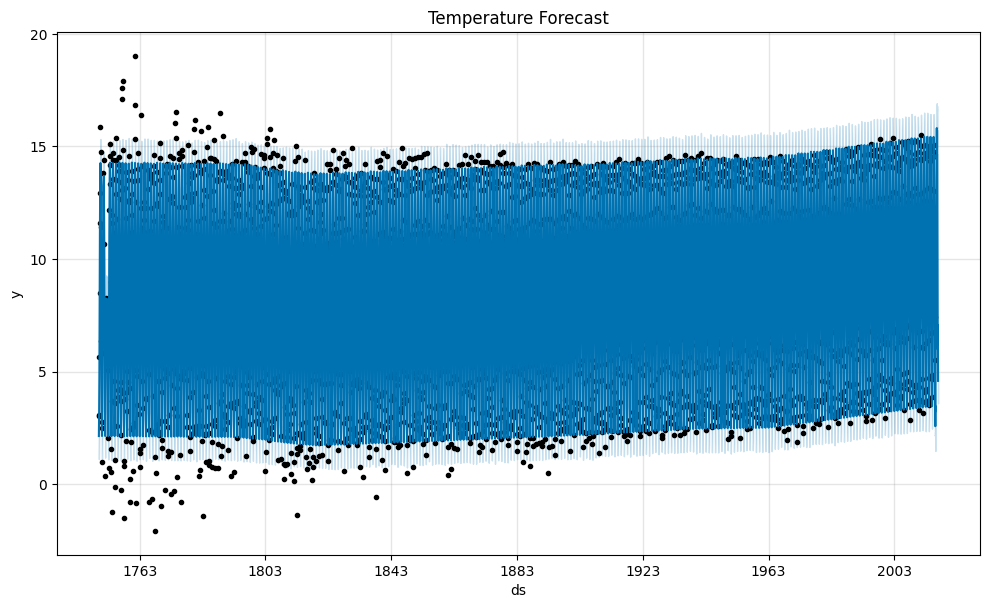

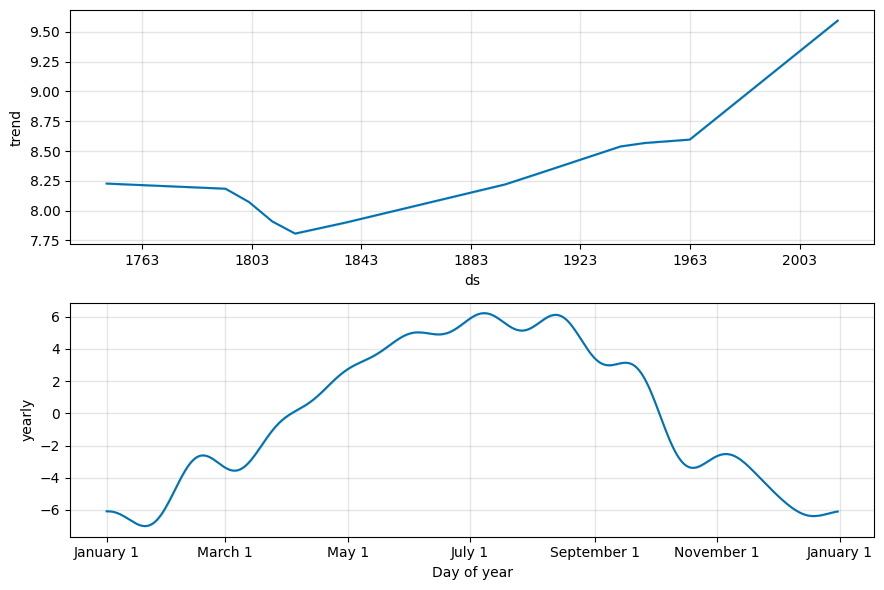

In [15]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = temperature_data[['LandAverageTemperature']].reset_index()
prophet_data.columns = ['ds', 'y']

# Train Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Make future predictions
future = prophet_model.make_future_dataframe(periods=365)  # Forecast for 1 year
forecast = prophet_model.predict(future)

# Plot predictions
fig = prophet_model.plot(forecast)
plt.title('Temperature Forecast')
plt.show()

# Plot components
fig_components = prophet_model.plot_components(forecast)
